In [27]:
import os 
import numpy as np
import pandas as pd
import polars as pl 
import warnings 
import sys 
sys.path.append('./GA_Shane')
import glob
import tsfel
from tqdm import tqdm
from joblib import Parallel, delayed


from sklearn.feature_selection import VarianceThreshold
from sklearn import preprocessing

warnings.filterwarnings('ignore')

code = 'RB'
roll = 5
label = 30
test_start = '2023-01-01'
fix = 513

part = '20250411_165242_sftNYO'
dir = f'E:/dragon/GA_Shane/outputs/{part}'

window_size = 10 
cfg = tsfel.get_features_by_domain(['statistical'])

""" 
Data 
"""
file_name_1 = glob.glob(os.path.join(dir, '*_output_axis.csv'))[0]
df = pd.read_csv(file_name_1).sort_values('eob')

file_name_2 = glob.glob(os.path.join(dir, f'*_output_axis_Label_{str(fix)}.csv'))[0]
df_label = pd.read_csv(file_name_2)


df = df.merge(df_label[['datelist','state']], left_on='eob',right_on='datelist',how='left')
df_label = df[['eob','state']]
df.drop(columns=['datelist'],inplace=True)

""" 
Feature Generation
"""
features = ['open','high','low','close','volume']
X = df.copy(deep=True)[features+['state']]
X[features] = X[features].shift(1) # 因为是需要预测当期的状态，所以需要将X shift1
print("Original X.shape: ", X.shape)

X = X.dropna()

price_features = ['open','high','low','close']
volume_features = ['volume',]

print('base feature :', features)

for feature in volume_features:
    X[feature] = X[feature] + 1e-5 # avoid 0 volume

for feature in features:
    X[feature] = np.log(X[feature])

for i in range(1,10,2):
    for feature in features:
        X[f'{feature}_diff_{i}'] = X[feature].diff(i)

Original X.shape:  (23806, 6)
base feature : ['open', 'high', 'low', 'close', 'volume']


In [28]:
from GA_Shane.functions import *

print('**** Entropy ****')
window_size = 20
m = 2
r_ratio = 1
use_std = True 

feature = X['volume'].values
arr_base = dynamic_sample_entropy_numba(feature[-window_size:], m, r_ratio, use_std) 
print(arr_base)
arr = rolling_apply(dynamic_sample_entropy_numba, feature, window_size, m, r_ratio, use_std)
print(arr)

**** Entropy ****
0.45786889677974213
[       nan        nan        nan ... 0.6715337  0.48954823 0.4578689 ]


In [24]:
np.isnan(arr).sum()

19

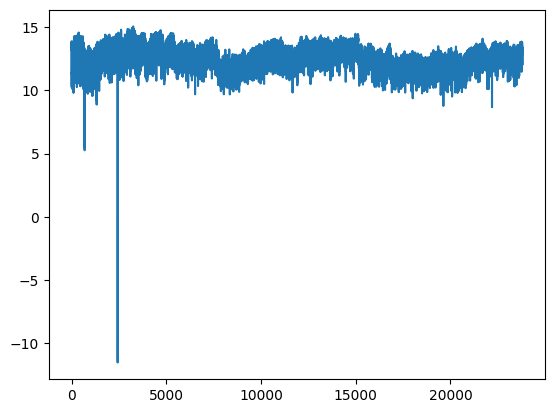

In [25]:
import matplotlib.pyplot as plt 
plt.plot(feature)

In [42]:
def getWeights(d, size):
    """
    Compute weights for the weighted moving average
    """
    w = [1.]
    for k in range(1, size):
        w.append(-w[-1] * (d - k + 1) / k)
    w = np.array(w[::-1]).reshape(-1, 1)
    return w

def fracDiff(series, d, thres=0.01):
    """
    Fractionally differentiate time series
    
    Parameters:
    -----------
    series: pd.DataFrame
        Time series to difference
    d: float
        Fractional difference order
    thres: float
        Threshold for weight truncation
    
    Returns:
    --------
    pd.DataFrame
        Fractionally differenced series
    """
    # 1) Compute weights for the longest series
    w = getWeights(d, series.shape[0])
    
    # 2) Determine initial calculations to be skipped based on weight-loss threshold
    w_ = np.cumsum(abs(w))
    w_ /= w_[-1]
    skip = w_[w_ > thres].shape[0]
    
    # 3) Apply weights to values
    df = {}
    for name in series.columns:
        # Prepare the series (forward fill NAs and drop remaining NAs)
        seriesF = series[[name]].fillna(method='ffill').dropna()
        df_ = pd.Series()
        
        # Calculate fractional differentiation
        for iloc in range(skip, seriesF.shape[0]):
            loc = seriesF.index[iloc]
            
            # Skip if original series has NA at this location
            if not np.isfinite(series.loc[loc, name]):
                continue
            
            # Calculate the weighted sum
            window = seriesF.loc[:loc]
            weights = w[-(iloc+1):, :]
            df_[loc] = np.dot(weights.T, window)[0, 0]
        
        df[name] = df_.copy(deep=True)
    
    # Combine all columns
    df = pd.concat(df, axis=1)
    return df

In [59]:
v.rolling(w).apply(lambda x: fast_fracdiff(x.values,d)[-1])

5           NaN
6           NaN
7           NaN
8           NaN
9           NaN
         ...   
600    8.462483
601    8.460229
602    8.460767
603    8.453383
604    8.451675
Name: open, Length: 600, dtype: float64

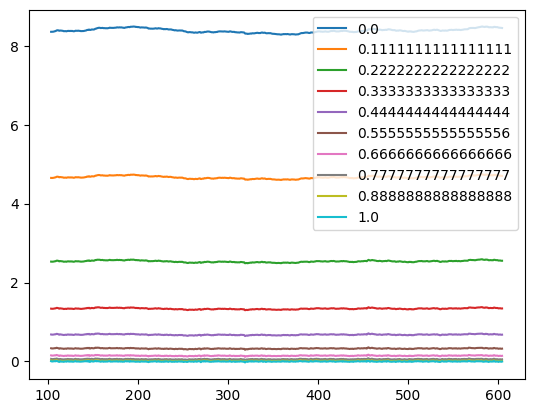

In [61]:
import matplotlib.pyplot as plt 
# for d in np.linspace(0,1,10):
#     plt.plot(fast_fracdiff(X['open'].iloc[:600],d),label=d)
# plt.legend()

w = 100
for d in np.linspace(0,1,10):
    v = X['open'].iloc[:600]
    plt.plot(v.rolling(w).apply(lambda x: fast_fracdiff(x.values,d)[-1]),label=d)
plt.legend()

In [ ]:
fast_fracdiff(X['open'].iloc[-60:-2], 0.5)

array([8.04267722, 4.02615766, 3.02077374, 2.51356753, 2.1957086 ,
       1.98120654, 1.81549696, 1.67999174, 1.57950663, 1.49228861,
       1.42162084, 1.34375711, 1.29386736, 1.24308481, 1.19849621,
       1.15499823, 1.11991657, 1.09198578, 1.06268671, 1.03698138,
       0.99840408, 0.97276462, 0.94907581, 0.92812003, 0.91036527,
       0.89973149, 0.88332051, 0.86929414, 0.84795665, 0.83308089,
       0.81412336, 0.80177958, 0.79077509, 0.77476853, 0.7665317 ,
       0.76020974, 0.75162474, 0.73390864, 0.7342205 , 0.72046398,
       0.715079  , 0.71324644, 0.70958655, 0.69453535, 0.68349041,
       0.68073021, 0.66755915, 0.6537515 , 0.65508933, 0.64743598,
       0.64447591, 0.63958808, 0.62868155, 0.61512317, 0.60409767,
       0.6048387 , 0.61090746, 0.60107942, 0.59485225, 0.58916266,
       0.58614167, 0.58749977, 0.57896889, 0.57766712, 0.57076281,
       0.5691166 , 0.56470693, 0.56133332, 0.5564213 , 0.54951242,
       0.55488895, 0.54693494, 0.54486092, 0.53848048, 0.54009

In [7]:
import pylab as pl

def fast_fracdiff(arr, d):
    T = len(arr)
    np2 = int(2 ** np.ceil(np.log2(2 * T - 1)))
    k = np.arange(1, T)
    b = (1,) + tuple(np.cumprod((k - d - 1) / k))
    z = (0,) * (np2 - T)
    z1 = b + z
    z2 = tuple(arr) + z
    dx = pl.ifft(pl.fft(z1) * pl.fft(z2))
    return  np.real(dx[0:T]) 


# fast_fracdiff(X['open'], 0.5)

In [ ]:
fast_fracdiff(X['open'].iloc[:-2], 0.5)

array([8.41507087, 4.20814974, 3.15908851, ..., 0.02651116, 0.02906441,
       0.03785539])

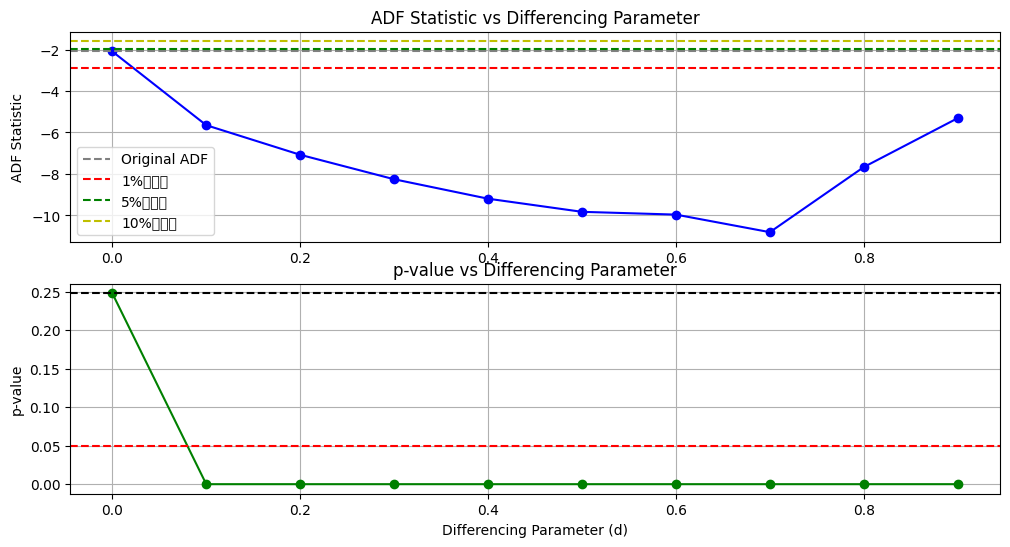

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# 生成示例非平稳时间序列（随机游走）
np.random.seed(42)
n = 100
arr = np.log(X['volume']+1e-5).cumsum().iloc[-60000:]

# 测试不同参数值
parameters = np.arange(0, 1, 0.1)  # 从0.1到1.0，步长0.1
# parameters = np.arange(0, 0.1, 0.01)  # 从0.1到1.0，步长0.
# parameters = np.arange(0, 0.02, 0.005)  # 从0.1到1.0，步长0.1


adf_stats = []
p_values = []



for param in parameters:
    arr2 = fast_fracdiff(arr, param)
    result = adfuller(arr2)  # Drop NA values that may result from differencing
    adf_stats.append(result[0])  # ADF statistic
    p_values.append(result[1])   # p-value

# Plot results
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(parameters, adf_stats, 'bo-')
plt.axhline(y=adfuller(arr)[0], color='grey', linestyle='--', label='Original ADF')
plt.axhline ( y = - 2.89 , color = 'r' , linestyle = '--' , label = '1%临界值' ) # 近似临界值 
plt.axhline ( y = - 1.98 , color = 'g' , linestyle = '--' , label = '5%临界值' ) 
plt.axhline ( y = - 1.60 , color = 'y' , linestyle = '--' , label = '10%临界值' )
plt.legend()
plt.title('ADF Statistic vs Differencing Parameter')
plt.ylabel('ADF Statistic')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(parameters, p_values, 'go-')
plt.axhline(y=0.05, color='r', linestyle='--', label='5% significance level')
plt.axhline(y=adfuller(arr)[1], color='k', linestyle='--', label='Original p-value')
plt.title('p-value vs Differencing Parameter')
plt.xlabel('Differencing Parameter (d)')
plt.ylabel('p-value')
plt.grid(True)

In [ ]:
result_df = pd.DataFrame(
    {'parameter':parameters,
    'adf':adf_stats,
    'p':p_values,}
)
print(result_df)
optimal_idx = np.argmax(np.array(p_values) < 0.01)  # First index where p < 0.05
optimal_param = parameters[optimal_idx]
print(optimal_param)

   parameter        adf             p
0        0.0  -2.090774  2.482407e-01
1        0.1  -5.647922  1.001402e-06
2        0.2  -7.075052  4.826089e-10
3        0.3  -8.254983  5.266739e-13
4        0.4  -9.193315  2.094780e-15
5        0.5  -9.825913  5.188556e-17
6        0.6  -9.960286  2.383609e-17
7        0.7 -10.807605  1.945222e-19
8        0.8  -7.666778  1.633236e-11
9        0.9  -5.307681  5.278587e-06
0.1


In [ ]:
import pylab as pl 
X['mid'] = np.log((np.exp(X['open']) + np.exp(X['close']))/2)
X['mid2'] = np.log((np.exp(X['high']) + np.exp(X['low']))/2)

price_features = ['open','high','low','close','mid','mid2']
volume_features = ['volume',]

dicts = []
for d in  np.arange(0, 1.1, 0.05):
    for feature in price_features:
        X[f'{feature}_frac'] = fast_fracdiff(X[feature], d=d)
        dicts.append({'feature':feature,'d':d, 'ic':X.iloc[:180000]['state'].corr(X.iloc[:180000][f'{feature}_frac'],method='spearman')})

In [ ]:
w = 100
d = 0.8
dicts = []
feature = 'high'
for w in range(1000,10000, 1000):
    v = X[feature]
    v2 = v.rolling(w).apply(lambda x: fast_fracdiff(x.values,d)[-1])
    X[f'{feature}_ffd_{w}_frac_{d}'] = v2 
    dicts.append({'feature':feature,'d':d, 'w':w,'ic':X.iloc[:180000]['state'].corr(X.iloc[:180000][f'{feature}_ffd_{w}_frac_{d}'] ,method='spearman')})

X[f'{feature}_frac'] = fast_fracdiff(X[feature], d=d)
dicts.append({'feature':feature,'d':d, 'w':'inf','ic':X.iloc[:180000]['state'].corr(X.iloc[:180000][f'{feature}_frac'],method='spearman')})

In [73]:
pd.DataFrame(dicts).sort_values('ic',key=np.abs,ascending=False).head(60)

,feature,d,w,ic
2,high,0.8,1200,0.553296
3,high,0.8,1400,0.553244
0,high,0.8,800,0.553079
1,high,0.8,1000,0.552971
5,high,0.8,1800,0.552955
4,high,0.8,1600,0.552540
6,high,0.8,2000,0.552499
7,high,0.8,inf,0.515253


In [ ]:
import math

def flux_perc(magnitude):
    sorted_data = np.sort(magnitude)
    lc_length = len(sorted_data)

    F_60_index = int(math.ceil(0.60 * lc_length))
    F_40_index = int(math.ceil(0.40 * lc_length))
    F_5_index = int(math.ceil(0.05 * lc_length))
    F_95_index = int(math.ceil(0.95 * lc_length))

    F_40_60 = sorted_data[F_60_index] - sorted_data[F_40_index]
    F_5_95 = sorted_data[F_95_index] - sorted_data[F_5_index]
    F_mid20 = F_40_60 / F_5_95
    return F_mid20

from scipy.signal import cwt, find_peaks_cwt, ricker, welch

cwt_param = [ka for ka in [2,6,9]]

def number_cwt_peaks(x, n=6):

    return len(find_peaks_cwt(vector=x, widths=np.array(list(range(1, n + 1))), wavelet=ricker))) for n in param]

number_cwt_peaks(X["close"])

2321

In [ ]:
d = 0.8
for feature in price_features:
    X[f'{feature}_frac'] = fast_fracdiff(X[feature], d=d)

In [ ]:
dicts = []
for feature in ['close']:
    X[f'{feature}_test'] = X[f'{feature}'].rolling(60).apply(flux_perc)
    dicts.append({'feature':feature,'d':d, 'ic':X.iloc[:180000]['state'].corr(X.iloc[:180000][f'{feature}_test'],method='spearman')})

In [ ]:
pd.DataFrame(dicts).sort_values('ic',key=np.abs,ascending=False).head(60)

,feature,d,ic
0,close,0.8,0.02542


In [37]:
def calculate_window_size(d, τ=1e-5, max_iter=1000):
    """
    计算固定分数差分窗口长度
    参数：
        d: 差分阶数 (0 < d < 1)
        τ: 权重截断阈值 (默认1e-5)
        max_iter: 最大迭代次数
    返回：
        W: 满足条件的最小窗口长度
        weights: 截断后的权重向量
    """
    weights = [1.0]  # 初始化ω₀
    cumulative_weight = 1.0  # 当前累计权重绝对值
    
    for k in range(1, max_iter):
        # 计算当前权重
        ω_k = -weights[-1] * (d - k + 1) / k
        weights.append(ω_k)
        cumulative_weight += abs(ω_k)
        
        # 检查尾部权重和
        tail_weight = sum(abs(w) for w in weights[k:])
        if tail_weight <= τ * cumulative_weight:
            return k, weights[:k+1]
    
    raise ValueError(f"未能在{max_iter}次迭代内收敛")

In [38]:
k, ws = calculate_window_size(0.8)

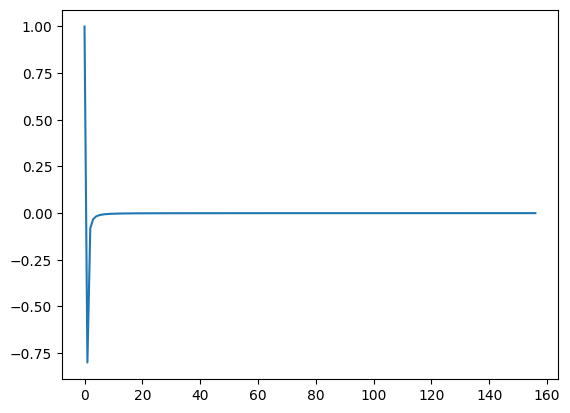

In [40]:
plt.plot(ws)

In [2]:

def _calculate_entropy(arr: np.ndarray) -> float:
    if arr.size == 0:
        return 0.0
    # Use pandas Series for convenient value_counts
    s = pd.Series(arr)
    p = s.value_counts(normalize=True)
    return -np.sum(p * np.log2(p + 1e-9))

def get_info_gain(arr1: np.ndarray, arr2: np.ndarray, train_n: int, valid_n: int, split_n: int) -> float:

    if len(arr1) != len(arr2):
        raise ValueError("Input arrays must have the same length")
    
    total_required = train_n + valid_n
    if len(arr1) < total_required:
         raise ValueError(f"Input arrays need at least {total_required} elements for train_n={train_n} and valid_n={valid_n}")


    # --- Data Splitting ---
    x_train = arr1[:train_n]
    y_train = arr2[:train_n]
    
    x_valid = arr1[train_n : train_n + valid_n]
    y_valid = arr2[train_n : train_n + valid_n]

    if x_train.size == 0 or x_valid.size == 0:
        return 0.0

    # --- Find Splits on Training Data ---
    H_y_train = _calculate_entropy(y_train)
    
    unique_vals = np.sort(np.unique(x_train))
    
    potential_splits = []
    if len(unique_vals) > 1:
        potential_splits = (unique_vals[:-1] + unique_vals[1:]) / 2.0

    split_evals = []
    n_train = len(x_train)

    if n_train > 0 and len(potential_splits) > 0:
        for split in potential_splits:
            left_mask = x_train <= split
            right_mask = ~left_mask
            
            y_left = y_train[left_mask]
            y_right = y_train[right_mask]
            
            n_left = len(y_left)
            n_right = len(y_right)

            if n_left == 0 or n_right == 0:
                continue

            H_left = _calculate_entropy(y_left)
            H_right = _calculate_entropy(y_right)
            
            cond_H = (n_left / n_train) * H_left + (n_right / n_train) * H_right
            ig = H_y_train - cond_H
            split_evals.append({'split': split, 'ig': ig})

    split_evals.sort(key=lambda x: x['ig'], reverse=True)
    
    best_splits = sorted([item['split'] for item in split_evals[:split_n]])
    
    # --- Apply Binning to Validation Data ---
    if len(best_splits) > 0:
        # np.digitize requires bins to be monotonically increasing
        bins = np.array(best_splits)
        # Indices correspond to bins: 0 for < bins[0], 1 for bins[0] <= x < bins[1], ..., len(bins) for >= bins[-1]
        x_valid_binned = np.digitize(x_valid, bins=bins, right=False)
    else:
        # If no splits found, assign all to a single bin (e.g., 0)
        x_valid_binned = np.zeros(len(x_valid), dtype=int)
        
    # --- Calculate IG on Validation Data ---
    H_y_valid = _calculate_entropy(y_valid)
    
    cond_H_valid = 0.0
    n_valid = len(x_valid)
    
    unique_bins = np.unique(x_valid_binned)

    if n_valid > 0 and len(unique_bins) > 0:
        for bin_val in unique_bins:
             y_in_bin = y_valid[x_valid_binned == bin_val]
             if y_in_bin.size > 0:
                H_group = _calculate_entropy(y_in_bin)
                prop = len(y_in_bin) / n_valid
                cond_H_valid += prop * H_group
        
        final_ig = H_y_valid - cond_H_valid
    else:
         final_ig = 0.0 # No gain if validation data is empty or no variation in bins

    return max(0.0, final_ig)

In [6]:
from GA_Shane.functions import *

print('**** Entropy ****')
m = 2
r_ratio = 1
use_std = True 

ig_dict = []

d = 0.9
w = 1000
price_features = ['close']
for feature in price_features + ['volume']:
    res = rolling_apply_last(fast_fracdiff,X[feature], w, d)
    info_gain = get_info_gain(res[w:], X['state'].values[w:], 1000, 10000, 30)
    ig_dict.append({'feature':feature,'info_gain':info_gain,'type':'frac','w':w})

for w in [20, 100]:
    for feature in price_features+['volume']:
        arr = rolling_apply(dynamic_sample_entropy_numba, X[feature].values, w, m, r_ratio, use_std)
        info_gain = get_info_gain(arr[w:], X['state'].values[w:], 1000, 10000, 30)
        ig_dict.append({'feature':feature,'info_gain':info_gain,'type':'entropy','w':w})


pd.DataFrame(ig_dict).sort_values('info_gain',ascending=False)

**** Entropy ****


,feature,info_gain,type,w
0,close,0.126360,frac,1000
5,volume,0.003402,entropy,100
3,volume,0.003219,entropy,20
4,close,0.003112,entropy,100
1,volume,0.002232,frac,1000
2,close,0.001898,entropy,20


In [ ]:
import tsfel
cfg = tsfel.get_features_by_domain(['temporal'])

window_size = 10
def extract_features_window(i, data_array, cfg, window_size):
    try:
        window_data = data_array[i-window_size:i, :]
        features = tsfel.time_series_features_extractor(
            cfg, window_data, window_size=window_size, overlap=0, verbose=0, fs=1
        )
        return i, features
    except Exception as e:
        print(f"Error at window {i}: {str(e)}")
        return i, None

# Feature extraction for training set
data_array = X.drop(columns=['state'])[['close']].diff(5).to_numpy()
indices = range(window_size, len(data_array))

# Process training data in parallel
with Parallel(n_jobs=-1, verbose=1, batch_size=100) as parallel:
    train_results = parallel(
        delayed(extract_features_window)(i, data_array, cfg, window_size) for i in indices
    )

# Filter, sort and concatenate training features
F_train = pd.concat(
    [feat for _, feat in sorted(
        [(idx, feat) for idx, feat in train_results if feat is not None],
        key=lambda x: x[0]
    )],
    axis=0, ignore_index=True
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 16040 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 23560 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 23781 out of 23781 | elapsed:    4.9s finished


In [57]:
F_train.index=X.index[window_size:]

In [58]:
X2 = pd.concat([X,F_train],axis=1)

In [59]:
X2 = X2.dropna()

In [61]:
ig_dict = []
for feature in tqdm(X2.columns):
    if feature == 'state':continue
    arr = X2[feature].values
    info_gain = get_info_gain(arr, X2['state'].values, 1000, 10000, 10)
    ig_dict.append({'feature':feature,'info_gain':info_gain,'type':'entropy','w':w})

100%|██████████| 45/45 [00:38<00:00,  1.18it/s]


In [62]:
pd.DataFrame(ig_dict).sort_values('info_gain',ascending=False).head(60).round(3)

,feature,info_gain,type,w
18,close_diff_5,0.329,entropy,100
13,close_diff_3,0.273,entropy,100
11,high_diff_3,0.261,entropy,100
16,high_diff_5,0.247,entropy,100
23,close_diff_7,0.245,entropy,100
12,low_diff_3,0.243,entropy,100
17,low_diff_5,0.236,entropy,100
10,open_diff_3,0.211,entropy,100
22,low_diff_7,0.165,entropy,100
15,open_diff_5,0.164,entropy,100
